## Data dictionary

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
|  0 | credit_policy     | 1 if the customer meets the credit underwriting criteria; 0 otherwise.                                                  |
|  1 | purpose           | The purpose of the loan.                                                                                                |
|  2 | int_rate          | The interest rate of the loan (more risky borrowers are assigned higher interest rates).                                |
|  3 | installment       | The monthly installments owed by the borrower if the loan is funded.                                                    |
|  4 | log_annual_inc    | The natural log of the self-reported annual income of the borrower.                                                     |
|  5 | dti               | The debt-to-income ratio of the borrower (amount of debt divided by annual income).                                     |
|  6 | fico              | The FICO credit score of the borrower.                                                                                  |
|  7 | days_with_cr_line | The number of days the borrower has had a credit line.                                                                  |
|  8 | revol_bal         | The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).                           |
|  9 | revol_util        | The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available). |
| 10 | inq_last_6mths    | The borrower's number of inquiries by creditors in the last 6 months.                                                   |
| 11 | delinq_2yrs       | The number of times the borrower had been 30+ days past due on a payment in the past 2 years.                           |
| 12 | pub_rec           | The borrower's number of derogatory public records.                                                                     |
| 13 | not_fully_paid    | 1 if the loan is not fully paid; 0 otherwise.   

[Source](https://www.kaggle.com/itssuru/loan-data) of dataset.

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [77]:
df = pd.read_csv("loan_data.csv")
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [78]:
print(df['credit.policy'].value_counts())
print("=====================================")
print(df['purpose'].value_counts())



credit.policy
1    7710
0    1868
Name: count, dtype: int64
purpose
debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
Name: count, dtype: int64


In [79]:
df.dropna(inplace=True)

In [80]:
X = df.drop(['not.fully.paid', 'int.rate'], axis=1)
y = df['not.fully.paid']


In [81]:
# Encoding categorical features
encoder = LabelEncoder()
X['purpose'] = encoder.fit_transform(X['purpose'])

# Scaling numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [82]:
encoding_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
encoding_mapping

{'all_other': 0,
 'credit_card': 1,
 'debt_consolidation': 2,
 'educational': 3,
 'home_improvement': 4,
 'major_purchase': 5,
 'small_business': 6}

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [84]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best = grid_search.best_params_

LR

In [85]:
model = LogisticRegression(max_iter=1000, C=best['C'], penalty=best['penalty'], solver=best['solver'])
model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')

In [86]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [87]:
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      1602
           1       0.53      0.03      0.05       314

    accuracy                           0.84      1916
   macro avg       0.69      0.51      0.48      1916
weighted avg       0.79      0.84      0.77      1916



In [88]:
## dumps

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(model, 'loan_predict.joblib')

['loan_predict.joblib']

RF

In [89]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predictions
rf_preds = rf.predict(X_test)

# Performance

print("Acc: ", accuracy_score(y_test, rf_preds))
print("Classification Report:\n", classification_report(y_test, rf_preds))

Acc:  0.8345511482254697
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91      1602
           1       0.40      0.02      0.04       314

    accuracy                           0.83      1916
   macro avg       0.62      0.51      0.47      1916
weighted avg       0.77      0.83      0.77      1916



In [90]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train , y_train)

#Predict on test data
nb_preds = naive_bayes.predict(X_test)

# Test set performance: 0.7516
print("Acc: ", accuracy_score(y_test, nb_preds))
print("Classification Report:\n", classification_report(y_test, nb_preds))


# Fitting Model: Bernouli
naive_bayes = BernoulliNB()
naive_bayes.fit(X_train , y_train)


#Predict on test data
nb_preds = naive_bayes.predict(X_test)

# Test set performance: 0.7865
print("Acc: ", accuracy_score(y_test, nb_preds))
print("Classification Report:\n", classification_report(y_test, nb_preds))

Acc:  0.8115866388308977
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      1602
           1       0.36      0.20      0.26       314

    accuracy                           0.81      1916
   macro avg       0.61      0.56      0.57      1916
weighted avg       0.77      0.81      0.79      1916

Acc:  0.837160751565762
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91      1602
           1       0.53      0.05      0.09       314

    accuracy                           0.84      1916
   macro avg       0.69      0.52      0.50      1916
weighted avg       0.79      0.84      0.78      1916



In [91]:
mapping = {
    'all_other': 0,
    'credit_card': 1,
    'debt_consolidation': 2,
    'educational': 3,
    'home_improvement': 4,
    'major_purchase': 5,
    'small_business': 6
}

columns_order = [
    "credit.policy", "purpose", "installment", "log.annual.inc",
    "dti", "fico", "days.with.cr.line", "revol.bal",
    "revol.util", "inq.last.6mths", "delinq.2yrs", "pub.rec"
]

data = pd.read_json("d.json").to_dict()["data"]
data['purpose'] = mapping[data['purpose']]
input_df = pd.DataFrame([data], columns=columns_order)

# Scale tthe input data
scaler = joblib.load('scaler.pkl')
input_df = scaler.transform(input_df)

In [92]:
prob_default = model.predict_proba(input_df)[:, 1][0]
prob_default

0.13236186768606606

In [93]:
df[df['not.fully.paid'] == 0].sample().drop(['not.fully.paid', 'int.rate'], axis=1).to_json(orient="records")

'[{"credit.policy":1,"purpose":"debt_consolidation","installment":405.25,"log.annual.inc":10.4341158,"dti":19.55,"fico":682,"days.with.cr.line":2490.0,"revol.bal":23806,"revol.util":76.1,"inq.last.6mths":0,"delinq.2yrs":0,"pub.rec":0},{"credit.policy":1,"purpose":"credit_card","installment":315.2,"log.annual.inc":10.80972795,"dti":15.85,"fico":682,"days.with.cr.line":2520.0,"revol.bal":6012,"revol.util":74.2,"inq.last.6mths":1,"delinq.2yrs":0,"pub.rec":0},{"credit.policy":1,"purpose":"credit_card","installment":164.23,"log.annual.inc":11.28978191,"dti":1.21,"fico":672,"days.with.cr.line":3990.0,"revol.bal":27185,"revol.util":16.1,"inq.last.6mths":3,"delinq.2yrs":0,"pub.rec":1}]'

In [94]:
model2 = joblib.load('loan_predict.joblib')
prob_default2 = model2.predict_proba(input_df)[:, 1][0]
prob_default2

0.13236186768606606

In [95]:
## defaulting is 1 => 
0.19271573707206544
0.3062922391609581
0.28750689922069234
0.3258431464660883

## paying is 0 => 
0.30867979117675043
0.17066815731350388
0.09372335787632106
0.12704295063941334

0.12704295063941334

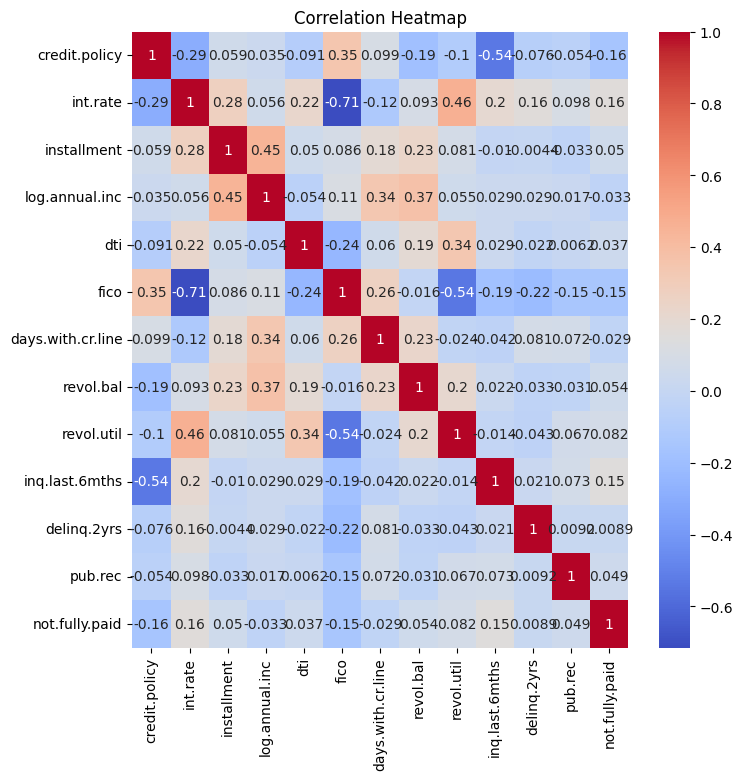

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = df.select_dtypes(include=['int64', 'float64'])

# Visualize the correlation between numeric features
plt.figure(figsize=(8, 8))
sns.heatmap(data=numeric_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [112]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def calculate_metrics(probs, true_labels):
    predictions = (probs >= 0.5).astype(int)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, f1

def optimize_weights(model1_probs, model2_probs, true_labels):
    best_weights = None
    best_score = 0
    
    for weight1 in np.linspace(0, 1, 11):
        weight2 = 1 - weight1
        
        combined_probs = weight1 * model1_probs + weight2 * model2_probs
        accuracy, f1 = calculate_metrics(combined_probs, true_labels)
        
        # Combine accuracy and F1-score using a weighted sum
        score = 0.7 * accuracy + 0.3 * f1
        
        if score > best_score:
            best_score = score
            best_weights = (weight1, weight2)
    
    return best_weights

# Load your models and test data
model1 = joblib.load('loan_predict.joblib')
model2 = joblib.load('loan_predict_resampled.joblib')

# Replace these with actual probability predictions and true labels
model1_probs = model1.predict_proba(X_test)[:, 1]  # Probability predictions from model 1 for X_test
model2_probs = model2.predict_proba(X_test)[:, 1]  # Probability predictions from model 2 for X_test

optimized_weights = optimize_weights(model1_probs, model2_probs, y_test)
print("Optimized Weights:", optimized_weights)


Optimized Weights: (0.4, 0.6)
